<a href="https://colab.research.google.com/github/hvakanksha/Twitter-Airline-Sentiment-Analysis/blob/main/RNN_LSTM_and_Conv1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries and Data

In [1]:
import numpy as np 
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from tensorflow.keras.utils import to_categorical

import re
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
tweets = pd.read_csv("Tweets.csv")
tweets.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
print(tweets.columns)
df = pd.DataFrame({
    "sentiment":tweets.airline_sentiment,
    "text":tweets.text
})
print(f"Shape of our dataset >> {df.shape}")
df.head()

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')
Shape of our dataset >> (14640, 2)


,sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


#Data Preprocessing and Cleaning

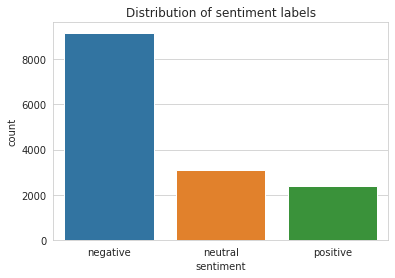

In [6]:
df.sentiment.replace(['negative','neutral','positive'],[-1,0,1],inplace=True)
df.sample(5)

sns.set_style("whitegrid")
sns.countplot(data=df,x='sentiment')
index = [0,1,2]
plt.xticks(index,['negative','neutral','positive'])
plt.title("Distribution of sentiment labels")
plt.show()

In [8]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
stop_words = set(stopwords.words('english'))

shortword = re.compile(r"\b\w{1,2}\b")
url = re.compile(r"https?:*/+[a-zA-Z0-9./]*")

def clean(text):
    text = re.sub(url,'',text)
    text = re.sub(shortword,'',text)
    text = text.replace('@','')
    text = text.replace('#','')
    
    text = text.split()
    text = [word for word in text if word not in stop_words]
    text = " ".join(text)
    
    return text

df.text = df.text.apply(clean)
df.text[:15]

0                     VirginAmerica What dhepburn said.
1     VirginAmerica plus you' added commercials expe...
2     VirginAmerica didn' today... Must mean need ta...
3     VirginAmerica ' really aggressive blast obnoxi...
4                  VirginAmerica ' really big bad thing
5     VirginAmerica seriously would pay $ flight sea...
6     VirginAmerica yes, nearly every time fly “ear ...
7     VirginAmerica Really missed prime opportunity ...
8                virginamerica Well, didn'…but NOW ! :-
9     VirginAmerica amazing, arrived hour early. You...
10    VirginAmerica know suicide second leading caus...
11    VirginAmerica &; pretty graphics. much better ...
12    VirginAmerica This great deal! Already thinkin...
13    VirginAmerica virginmedia ' flying fabulous Se...
14                                VirginAmerica Thanks!
Name: text, dtype: object

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
print(f"{len(tokenizer.word_index)} words are used\n")

counts = tokenizer.word_counts
print(len(counts))

total_freq = 0
rare_freq = 0
rare_counts = 0
thread=2

for key,value in counts.items():
    total_freq += value
    if value<thread:
        rare_freq += value
        rare_counts += value

print(f"{rare_counts} are used less than {thread} times")
print(f"And these words accounts for {np.round(rare_freq/total_freq*100,2)}% of whole texts")

14088 words are used

14088
7772 are used less than 2 times
And these words accounts for 5.04% of whole texts


In [11]:
print("Tokenize only 7000 words.\nOther words are considered OOV")
word_size=7000
vocab_size = word_size+1
tokenizer = Tokenizer(num_words=word_size)

tokenizer.fit_on_texts(df.text)
tokenized = tokenizer.texts_to_sequences(df.text)

print("\nSamples\n")
print(tokenized[0])
print(tokenized[1])
print(len(tokenized))

Tokenize only 7000 words.
Other words are considered OOV

Samples

[30, 106, 6317, 143]
[30, 450, 85, 1022, 2339, 120, 6318]
14640


Average length of each row >> 10.0448087431694
Maximum length of each row >> 22


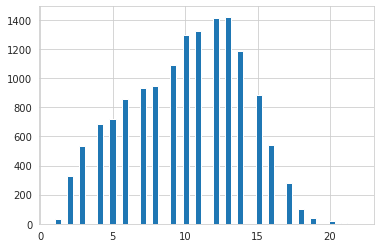

Pad all sequences into size of 20
(14640, 20)
Padded samples
[  30  106 6317  143    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
[  30  450   85 1022 2339  120 6318    0    0    0    0    0    0    0
    0    0    0    0    0    0]


In [12]:
lengths = [len(s) for s in tokenized]
print(f"Average length of each row >> {np.mean(lengths)}")
print(f"Maximum length of each row >> {np.max(lengths)}")

plt.hist(lengths,bins=50)
plt.show()

sequence_size = 20
print(f"Pad all sequences into size of {sequence_size}")

padded = pad_sequences(tokenized,maxlen=sequence_size,padding='post',truncating='post')
print(padded.shape)
print("Padded samples")
print(padded[0])
print(padded[1])

In [13]:
data = padded
label = to_categorical(df.sentiment,num_classes=3)

print("shape of data >>",data.shape)
print("shape of label >>",label.shape)

print("\nSamples of label data")
print(label[0])
print(label[1])

shape of data >> (14640, 20)
shape of label >> (14640, 3)

Samples of label data
[1. 0. 0.]
[0. 1. 0.]


#Train:Test=70:30

shape of train data >> (10248, 20)
shape of test data >> (4392, 20)


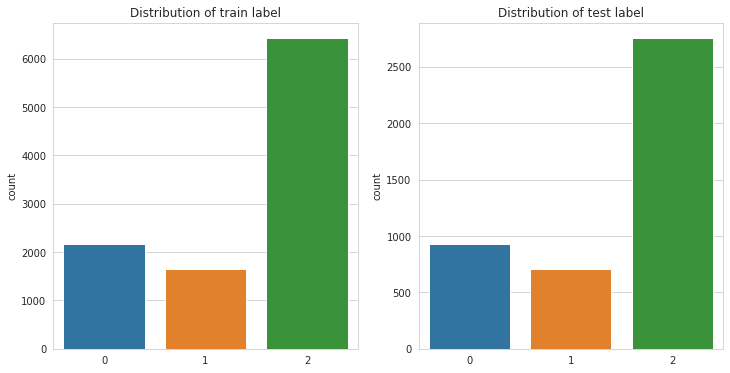

In [14]:
train_data,test_data,train_label,test_label = train_test_split(data,label,test_size=0.3,stratify=label,random_state=42)

print("shape of train data >>",train_data.shape)
print("shape of test data >>",test_data.shape)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
sns.countplot(x=np.argmax(train_label,axis=1))
plt.title("Distribution of train label")

ax2 = fig.add_subplot(1,2,2)
sns.countplot(x=np.argmax(test_label,axis=1))
plt.title("Distribution of test label")
plt.show()

index_to_sentiment = {
    0:'neutral',
    1:'positive',
    -1:'negative'
}


##LSTM using pre trained embedding vectors

In [15]:
import os

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2023-03-20 15:48:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-03-20 15:48:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-03-20 15:48:04--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [16]:
embedding_dict=dict()

f = open(os.path.join('glove.6B.100d.txt'),encoding='utf-8')
for line in f:
    tokens = line.split()
    word = tokens[0]
    word_vector = np.asarray(tokens[1:],dtype='float32')
    embedding_dict[word] = word_vector

f.close()

print(f"There are {len(embedding_dict)} embedding vectors in total")
print(f"Dimension of each vector >> {len(embedding_dict['read'])}")
embedding_size = len(embedding_dict['read'])


embedding_matrix = np.zeros((vocab_size,embedding_size))

for word,idx in tokenizer.word_index.items():
    if idx <= 7000:
        vector = embedding_dict.get(word)
        if vector is not None:
            embedding_matrix[idx] = np.asarray(vector,dtype='float32')

There are 400000 embedding vectors in total
Dimension of each vector >> 100


Build Stacked LSTM model (+ bidirectional, many-to-many)

In [17]:
from keras.layers import Input,Embedding,TimeDistributed,Bidirectional,LSTM,BatchNormalization,Dense,GlobalMaxPool1D,GlobalAveragePooling1D,Dropout,Masking
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.utils import plot_model

word_vec_size=100
hidden_size=128

def create_lstm():
    X = Input(shape=[sequence_size])
    H = Embedding(vocab_size,word_vec_size,input_length=sequence_size,weights=[embedding_matrix],trainable=False)(X)
    H = Masking(mask_value=0.0)(H)
    
    H = Bidirectional(LSTM(hidden_size,return_sequences=True))(H)
    H = Bidirectional(LSTM(int(hidden_size/2),return_sequences=True))(H)
    H = Bidirectional(LSTM(int(hidden_size/2),return_sequences=True))(H)
    
    H = GlobalMaxPool1D()(H)
    H = BatchNormalization()(H)
    H = Dense(32,activation='relu')(H)
    H = BatchNormalization()(H)
    Y = Dense(3,activation='softmax')(H)
    
    model = keras.models.Model(X,Y)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

es = EarlyStopping(monitor='val_accuracy',mode='min',patience=4,verbose=1)
rl = ReduceLROnPlateau(monitor='val_loss',mode='min',patience=3,verbose=1)

In [18]:
lstm_model = create_lstm()
plot_model(lstm_model)
lstm_history = lstm_model.fit(train_data,train_label,epochs=10,batch_size=64,validation_split=0.2,callbacks=[rl])
lstm_model.evaluate(test_data,test_label)

Epoch 1/10
129/129 [==============================] - 68s 324ms/step - loss: 0.8042 - accuracy: 0.6655 - val_loss: 0.8354 - val_accuracy: 0.6595 - lr: 0.0010
Epoch 2/10
129/129 [==============================] - 33s 254ms/step - loss: 0.6082 - accuracy: 0.7538 - val_loss: 0.7599 - val_accuracy: 0.7029 - lr: 0.0010
Epoch 3/10
129/129 [==============================] - 36s 278ms/step - loss: 0.5475 - accuracy: 0.7774 - val_loss: 0.7288 - val_accuracy: 0.7205 - lr: 0.0010
Epoch 4/10
129/129 [==============================] - 35s 269ms/step - loss: 0.5200 - accuracy: 0.7895 - val_loss: 0.7650 - val_accuracy: 0.6561 - lr: 0.0010
Epoch 5/10
129/129 [==============================] - 32s 250ms/step - loss: 0.4835 - accuracy: 0.8014 - val_loss: 0.6461 - val_accuracy: 0.7390 - lr: 0.0010
Epoch 6/10
129/129 [==============================] - 33s 260ms/step - loss: 0.4552 - accuracy: 0.8187 - val_loss: 0.6290 - val_accuracy: 0.7541 - lr: 0.0010
Epoch 7/10
129/129 [==============================] 

[0.6392237544059753, 0.7650273442268372]

##LSTM model without using pre-trained embedding vectors

In [19]:
word_vec_size=100
hidden_size=256

def create_lstm_no_emb():
    X = Input(shape=[sequence_size])
    H = Embedding(vocab_size,word_vec_size,input_length=sequence_size)(X)
    H = Masking(mask_value=0.0)(H)
    
    H = Bidirectional(LSTM(hidden_size,return_sequences=True))(H)
    H = BatchNormalization()(H)
    H = Bidirectional(LSTM(int(hidden_size/2),return_sequences=True))(H)
    H = BatchNormalization()(H)
    H = Bidirectional(LSTM(int(hidden_size/2),return_sequences=True))(H)
    
    H = GlobalMaxPool1D()(H)
    H = Dense(64,activation='relu')(H)
    H = Dense(32,activation='relu')(H)
    H = Dropout(0.2)(H)
    Y = Dense(3,activation='softmax')(H)
    
    model = keras.models.Model(X,Y)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [20]:
lstm_no = create_lstm_no_emb()
plot_model(lstm_no)
lstm_no_hist = lstm_model.fit(train_data,train_label,epochs=15,batch_size=64,validation_split=0.2,callbacks=[rl])
lstm_no.evaluate(test_data,test_label)

Epoch 1/15
129/129 [==============================] - 38s 290ms/step - loss: 0.2226 - accuracy: 0.9236 - val_loss: 0.6425 - val_accuracy: 0.7702 - lr: 1.0000e-04
Epoch 2/15
129/129 [==============================] - 34s 266ms/step - loss: 0.2098 - accuracy: 0.9263 - val_loss: 0.6425 - val_accuracy: 0.7702 - lr: 1.0000e-04
Epoch 3/15
129/129 [==============================] - 37s 289ms/step - loss: 0.1914 - accuracy: 0.9366 - val_loss: 0.6605 - val_accuracy: 0.7620 - lr: 1.0000e-04
Epoch 4/15
129/129 [==============================] - ETA: 0s - loss: 0.1803 - accuracy: 0.9382
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
129/129 [==============================] - 36s 277ms/step - loss: 0.1803 - accuracy: 0.9382 - val_loss: 0.6817 - val_accuracy: 0.7580 - lr: 1.0000e-04
Epoch 5/15
129/129 [==============================] - 33s 257ms/step - loss: 0.1645 - accuracy: 0.9466 - val_loss: 0.6791 - val_accuracy: 0.7678 - lr: 1.0000e-05
Epoch 6/15
129/129 [========

[1.0976312160491943, 0.3540528118610382]

##Conv1D model using pre-trained Embedding Vectors

In [21]:
from keras.layers import Conv1D,Concatenate,LeakyReLU,Flatten

def create_conv1d():
    X = Input(shape=[sequence_size])
    H = Embedding(vocab_size,word_vec_size,input_length=sequence_size,weights=[embedding_matrix],trainable=False,mask_zero=True)(X)
    H = Dropout(0.3)(H)
    
    num_filters=[256,256,128,128]
    kernel_sizes=[3,4,5,6]
    conv_blocks=[]
    
    for i in range(len(kernel_sizes)):
        conv = Conv1D(filters=num_filters[i],kernel_size=kernel_sizes[i],padding='valid',activation='relu')(H)
        conv = GlobalMaxPool1D()(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)
    
    H = Concatenate()(conv_blocks)
    H = Dropout(0.2)(H)
    
    H = Dense(128)(H)
    H = BatchNormalization()(H)
    H = LeakyReLU()(H)
    
    H = Dense(16)(H)
    H = BatchNormalization()(H)
    H = LeakyReLU()(H)
    
    Y = Dense(3,activation='softmax')(H)
    
    model = keras.models.Model(X,Y)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [22]:
conv1d = create_conv1d()
plot_model(conv1d)
hist = conv1d.fit(train_data,train_label,epochs=10,validation_split=0.2,batch_size=64,callbacks=[rl])
conv1d.evaluate(test_data,test_label)

Epoch 1/10
129/129 [==============================] - 10s 58ms/step - loss: 0.7869 - accuracy: 0.6654 - val_loss: 0.6439 - val_accuracy: 0.7439 - lr: 0.0010
Epoch 2/10
129/129 [==============================] - 6s 44ms/step - loss: 0.6200 - accuracy: 0.7458 - val_loss: 0.5910 - val_accuracy: 0.7576 - lr: 0.0010
Epoch 3/10
129/129 [==============================] - 7s 56ms/step - loss: 0.5630 - accuracy: 0.7667 - val_loss: 0.5756 - val_accuracy: 0.7615 - lr: 0.0010
Epoch 4/10
129/129 [==============================] - 6s 46ms/step - loss: 0.5176 - accuracy: 0.7880 - val_loss: 0.5700 - val_accuracy: 0.7659 - lr: 0.0010
Epoch 5/10
129/129 [==============================] - 7s 56ms/step - loss: 0.4880 - accuracy: 0.7986 - val_loss: 0.5873 - val_accuracy: 0.7649 - lr: 0.0010
Epoch 6/10
129/129 [==============================] - 6s 46ms/step - loss: 0.4438 - accuracy: 0.8226 - val_loss: 0.6083 - val_accuracy: 0.7380 - lr: 0.0010
Epoch 7/10
128/129 [============================>.] - ETA: 0s -

[0.5807927846908569, 0.7663934230804443]

#Train:Test=80:20

shape of train data >> (11712, 20)
shape of test data >> (2928, 20)


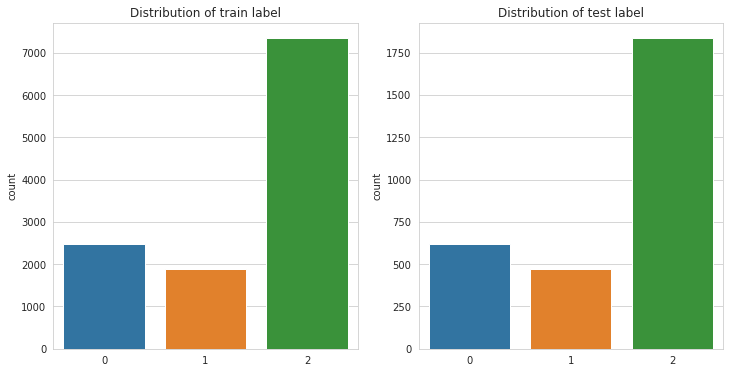

In [23]:
train_data,test_data,train_label,test_label = train_test_split(data,label,test_size=0.2,stratify=label,random_state=42)

print("shape of train data >>",train_data.shape)
print("shape of test data >>",test_data.shape)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
sns.countplot(x=np.argmax(train_label,axis=1))
plt.title("Distribution of train label")

ax2 = fig.add_subplot(1,2,2)
sns.countplot(x=np.argmax(test_label,axis=1))
plt.title("Distribution of test label")
plt.show()

index_to_sentiment = {
    0:'neutral',
    1:'positive',
    -1:'negative'
}

##LSTM model using pre-trained embedding vectors

In [24]:
embedding_dict=dict()

f = open(os.path.join('glove.6B.100d.txt'),encoding='utf-8')
for line in f:
    tokens = line.split()
    word = tokens[0]
    word_vector = np.asarray(tokens[1:],dtype='float32')
    embedding_dict[word] = word_vector

f.close()

print(f"There are {len(embedding_dict)} embedding vectors in total")
print(f"Dimension of each vector >> {len(embedding_dict['read'])}")
embedding_size = len(embedding_dict['read'])


embedding_matrix = np.zeros((vocab_size,embedding_size))

for word,idx in tokenizer.word_index.items():
    if idx <= 7000:
        vector = embedding_dict.get(word)
        if vector is not None:
            embedding_matrix[idx] = np.asarray(vector,dtype='float32')

There are 400000 embedding vectors in total
Dimension of each vector >> 100


In [25]:
from keras.layers import Input,Embedding,TimeDistributed,Bidirectional,LSTM,BatchNormalization,Dense,GlobalMaxPool1D,GlobalAveragePooling1D,Dropout,Masking
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.utils import plot_model

word_vec_size=100
hidden_size=128

def create_lstm():
    X = Input(shape=[sequence_size])
    H = Embedding(vocab_size,word_vec_size,input_length=sequence_size,weights=[embedding_matrix],trainable=False)(X)
    H = Masking(mask_value=0.0)(H)
    
    H = Bidirectional(LSTM(hidden_size,return_sequences=True))(H)
    H = Bidirectional(LSTM(int(hidden_size/2),return_sequences=True))(H)
    H = Bidirectional(LSTM(int(hidden_size/2),return_sequences=True))(H)
    
    H = GlobalMaxPool1D()(H)
    H = BatchNormalization()(H)
    H = Dense(32,activation='relu')(H)
    H = BatchNormalization()(H)
    Y = Dense(3,activation='softmax')(H)
    
    model = keras.models.Model(X,Y)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

es = EarlyStopping(monitor='val_accuracy',mode='min',patience=4,verbose=1)
rl = ReduceLROnPlateau(monitor='val_loss',mode='min',patience=3,verbose=1)

In [26]:
lstm_model = create_lstm()
plot_model(lstm_model)
lstm_history = lstm_model.fit(train_data,train_label,epochs=10,batch_size=64,validation_split=0.2,callbacks=[rl])
lstm_model.evaluate(test_data,test_label)

Epoch 1/10
147/147 [==============================] - 81s 350ms/step - loss: 0.7589 - accuracy: 0.6950 - val_loss: 0.8091 - val_accuracy: 0.6300 - lr: 0.0010
Epoch 2/10
147/147 [==============================] - 40s 272ms/step - loss: 0.6003 - accuracy: 0.7600 - val_loss: 0.7303 - val_accuracy: 0.6923 - lr: 0.0010
Epoch 3/10
147/147 [==============================] - 39s 266ms/step - loss: 0.5422 - accuracy: 0.7790 - val_loss: 0.7021 - val_accuracy: 0.6970 - lr: 0.0010
Epoch 4/10
147/147 [==============================] - 39s 268ms/step - loss: 0.5019 - accuracy: 0.7987 - val_loss: 0.5854 - val_accuracy: 0.7546 - lr: 0.0010
Epoch 5/10
147/147 [==============================] - 39s 267ms/step - loss: 0.4704 - accuracy: 0.8094 - val_loss: 0.5758 - val_accuracy: 0.7742 - lr: 0.0010
Epoch 6/10
147/147 [==============================] - 40s 269ms/step - loss: 0.4391 - accuracy: 0.8236 - val_loss: 0.6016 - val_accuracy: 0.7781 - lr: 0.0010
Epoch 7/10
147/147 [==============================] 

[0.6619646549224854, 0.7732240557670593]

 ## LSTM model without using pre-trained embedding vectors

In [27]:
word_vec_size=100
hidden_size=256

def create_lstm_no_emb():
    X = Input(shape=[sequence_size])
    H = Embedding(vocab_size,word_vec_size,input_length=sequence_size)(X)
    H = Masking(mask_value=0.0)(H)
    
    H = Bidirectional(LSTM(hidden_size,return_sequences=True))(H)
    H = BatchNormalization()(H)
    H = Bidirectional(LSTM(int(hidden_size/2),return_sequences=True))(H)
    H = BatchNormalization()(H)
    H = Bidirectional(LSTM(int(hidden_size/2),return_sequences=True))(H)
    
    H = GlobalMaxPool1D()(H)
    H = Dense(64,activation='relu')(H)
    H = Dense(32,activation='relu')(H)
    H = Dropout(0.2)(H)
    Y = Dense(3,activation='softmax')(H)
    
    model = keras.models.Model(X,Y)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [28]:
lstm_no = create_lstm_no_emb()
plot_model(lstm_no)
lstm_no_hist = lstm_model.fit(train_data,train_label,epochs=15,batch_size=64,validation_split=0.2,callbacks=[rl])
lstm_no.evaluate(test_data,test_label)

Epoch 1/15
147/147 [==============================] - 39s 265ms/step - loss: 0.2193 - accuracy: 0.9240 - val_loss: 0.5819 - val_accuracy: 0.7866 - lr: 1.0000e-04
Epoch 2/15
147/147 [==============================] - 39s 265ms/step - loss: 0.2074 - accuracy: 0.9304 - val_loss: 0.5984 - val_accuracy: 0.7793 - lr: 1.0000e-04
Epoch 3/15
147/147 [==============================] - 39s 264ms/step - loss: 0.1945 - accuracy: 0.9320 - val_loss: 0.6152 - val_accuracy: 0.7836 - lr: 1.0000e-04
Epoch 4/15
147/147 [==============================] - ETA: 0s - loss: 0.1822 - accuracy: 0.9386
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
147/147 [==============================] - 39s 266ms/step - loss: 0.1822 - accuracy: 0.9386 - val_loss: 0.6251 - val_accuracy: 0.7819 - lr: 1.0000e-04
Epoch 5/15
147/147 [==============================] - 39s 266ms/step - loss: 0.1691 - accuracy: 0.9463 - val_loss: 0.6244 - val_accuracy: 0.7810 - lr: 1.0000e-05
Epoch 6/15
147/147 [========

[1.0987484455108643, 0.22131147980690002]

##Conv1D model using pre-trained Embedding Vectors

In [29]:
from keras.layers import Conv1D,Concatenate,LeakyReLU,Flatten

def create_conv1d():
    X = Input(shape=[sequence_size])
    H = Embedding(vocab_size,word_vec_size,input_length=sequence_size,weights=[embedding_matrix],trainable=False,mask_zero=True)(X)
    H = Dropout(0.3)(H)
    
    num_filters=[256,256,128,128]
    kernel_sizes=[3,4,5,6]
    conv_blocks=[]
    
    for i in range(len(kernel_sizes)):
        conv = Conv1D(filters=num_filters[i],kernel_size=kernel_sizes[i],padding='valid',activation='relu')(H)
        conv = GlobalMaxPool1D()(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)
    
    H = Concatenate()(conv_blocks)
    H = Dropout(0.2)(H)
    
    H = Dense(128)(H)
    H = BatchNormalization()(H)
    H = LeakyReLU()(H)
    
    H = Dense(16)(H)
    H = BatchNormalization()(H)
    H = LeakyReLU()(H)
    
    Y = Dense(3,activation='softmax')(H)
    
    model = keras.models.Model(X,Y)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [30]:
conv1d = create_conv1d()
plot_model(conv1d)
hist = conv1d.fit(train_data,train_label,epochs=10,validation_split=0.2,batch_size=64,callbacks=[rl])
conv1d.evaluate(test_data,test_label)

Epoch 1/10
147/147 [==============================] - 10s 50ms/step - loss: 0.7677 - accuracy: 0.6806 - val_loss: 0.6190 - val_accuracy: 0.7469 - lr: 0.0010
Epoch 2/10
147/147 [==============================] - 8s 53ms/step - loss: 0.6146 - accuracy: 0.7511 - val_loss: 0.5354 - val_accuracy: 0.7742 - lr: 0.0010
Epoch 3/10
147/147 [==============================] - 7s 45ms/step - loss: 0.5585 - accuracy: 0.7733 - val_loss: 0.5595 - val_accuracy: 0.7606 - lr: 0.0010
Epoch 4/10
147/147 [==============================] - 8s 54ms/step - loss: 0.5202 - accuracy: 0.7850 - val_loss: 0.5288 - val_accuracy: 0.7836 - lr: 0.0010
Epoch 5/10
147/147 [==============================] - 7s 44ms/step - loss: 0.4842 - accuracy: 0.8028 - val_loss: 0.5290 - val_accuracy: 0.7840 - lr: 0.0010
Epoch 6/10
147/147 [==============================] - 8s 54ms/step - loss: 0.4410 - accuracy: 0.8225 - val_loss: 0.5406 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 7/10
146/147 [============================>.] - ETA: 0s -

[0.5920613408088684, 0.755464494228363]

#Train:Test=60:40

shape of train data >> (8784, 20)
shape of test data >> (5856, 20)


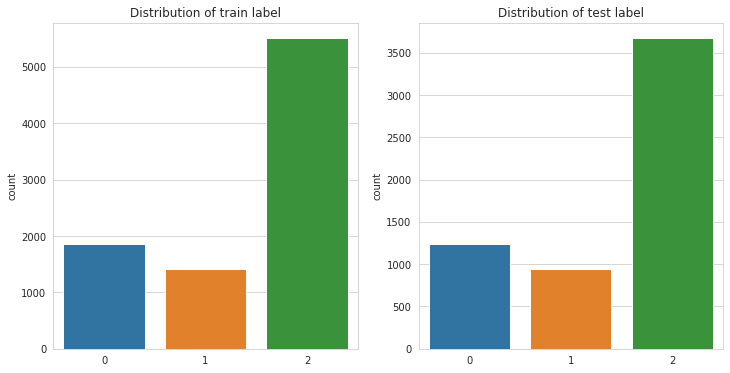

In [31]:
train_data,test_data,train_label,test_label = train_test_split(data,label,test_size=0.4,stratify=label,random_state=42)

print("shape of train data >>",train_data.shape)
print("shape of test data >>",test_data.shape)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
sns.countplot(x=np.argmax(train_label,axis=1))
plt.title("Distribution of train label")

ax2 = fig.add_subplot(1,2,2)
sns.countplot(x=np.argmax(test_label,axis=1))
plt.title("Distribution of test label")
plt.show()

index_to_sentiment = {
    0:'neutral',
    1:'positive',
    -1:'negative'
}

##LSTM model using pre-trained embedding vectors

In [32]:
embedding_dict=dict()

f = open(os.path.join('glove.6B.100d.txt'),encoding='utf-8')
for line in f:
    tokens = line.split()
    word = tokens[0]
    word_vector = np.asarray(tokens[1:],dtype='float32')
    embedding_dict[word] = word_vector

f.close()

print(f"There are {len(embedding_dict)} embedding vectors in total")
print(f"Dimension of each vector >> {len(embedding_dict['read'])}")
embedding_size = len(embedding_dict['read'])


embedding_matrix = np.zeros((vocab_size,embedding_size))

for word,idx in tokenizer.word_index.items():
    if idx <= 7000:
        vector = embedding_dict.get(word)
        if vector is not None:
            embedding_matrix[idx] = np.asarray(vector,dtype='float32')

There are 400000 embedding vectors in total
Dimension of each vector >> 100


LSTM model (+ bidirectional, many-to-many)

In [33]:
from keras.layers import Input,Embedding,TimeDistributed,Bidirectional,LSTM,BatchNormalization,Dense,GlobalMaxPool1D,GlobalAveragePooling1D,Dropout,Masking
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.utils import plot_model

word_vec_size=100
hidden_size=128

def create_lstm():
    X = Input(shape=[sequence_size])
    H = Embedding(vocab_size,word_vec_size,input_length=sequence_size,weights=[embedding_matrix],trainable=False)(X)
    H = Masking(mask_value=0.0)(H)
    
    H = Bidirectional(LSTM(hidden_size,return_sequences=True))(H)
    H = Bidirectional(LSTM(int(hidden_size/2),return_sequences=True))(H)
    H = Bidirectional(LSTM(int(hidden_size/2),return_sequences=True))(H)
    
    H = GlobalMaxPool1D()(H)
    H = BatchNormalization()(H)
    H = Dense(32,activation='relu')(H)
    H = BatchNormalization()(H)
    Y = Dense(3,activation='softmax')(H)
    
    model = keras.models.Model(X,Y)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

es = EarlyStopping(monitor='val_accuracy',mode='min',patience=4,verbose=1)
rl = ReduceLROnPlateau(monitor='val_loss',mode='min',patience=3,verbose=1)

In [34]:
lstm_model = create_lstm()
plot_model(lstm_model)
lstm_history = lstm_model.fit(train_data,train_label,epochs=10,batch_size=64,validation_split=0.2,callbacks=[rl])
lstm_model.evaluate(test_data,test_label)

Epoch 1/10
110/110 [==============================] - 69s 350ms/step - loss: 0.7876 - accuracy: 0.6821 - val_loss: 0.8262 - val_accuracy: 0.6232 - lr: 0.0010
Epoch 2/10
110/110 [==============================] - 30s 276ms/step - loss: 0.6154 - accuracy: 0.7596 - val_loss: 0.7718 - val_accuracy: 0.6528 - lr: 0.0010
Epoch 3/10
110/110 [==============================] - 30s 269ms/step - loss: 0.5577 - accuracy: 0.7740 - val_loss: 0.7214 - val_accuracy: 0.6927 - lr: 0.0010
Epoch 4/10
110/110 [==============================] - 30s 271ms/step - loss: 0.5200 - accuracy: 0.7907 - val_loss: 0.6463 - val_accuracy: 0.7319 - lr: 0.0010
Epoch 5/10
110/110 [==============================] - 30s 270ms/step - loss: 0.4806 - accuracy: 0.8032 - val_loss: 0.6055 - val_accuracy: 0.7570 - lr: 0.0010
Epoch 6/10
110/110 [==============================] - 32s 291ms/step - loss: 0.4441 - accuracy: 0.8224 - val_loss: 0.6605 - val_accuracy: 0.7507 - lr: 0.0010
Epoch 7/10
110/110 [==============================] 

[0.6282838582992554, 0.7665641903877258]

##LSTM model without using pre-trained embedding vectors

In [35]:
word_vec_size=100
hidden_size=256

def create_lstm_no_emb():
    X = Input(shape=[sequence_size])
    H = Embedding(vocab_size,word_vec_size,input_length=sequence_size)(X)
    H = Masking(mask_value=0.0)(H)
    
    H = Bidirectional(LSTM(hidden_size,return_sequences=True))(H)
    H = BatchNormalization()(H)
    H = Bidirectional(LSTM(int(hidden_size/2),return_sequences=True))(H)
    H = BatchNormalization()(H)
    H = Bidirectional(LSTM(int(hidden_size/2),return_sequences=True))(H)
    
    H = GlobalMaxPool1D()(H)
    H = Dense(64,activation='relu')(H)
    H = Dense(32,activation='relu')(H)
    H = Dropout(0.2)(H)
    Y = Dense(3,activation='softmax')(H)
    
    model = keras.models.Model(X,Y)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [36]:
lstm_no = create_lstm_no_emb()
plot_model(lstm_no)
lstm_no_hist = lstm_model.fit(train_data,train_label,epochs=15,batch_size=64,validation_split=0.2,callbacks=[rl])
lstm_no.evaluate(test_data,test_label)

Epoch 1/15
110/110 [==============================] - 29s 263ms/step - loss: 0.2324 - accuracy: 0.9169 - val_loss: 0.6397 - val_accuracy: 0.7627 - lr: 1.0000e-04
Epoch 2/15
110/110 [==============================] - 33s 298ms/step - loss: 0.2157 - accuracy: 0.9254 - val_loss: 0.6600 - val_accuracy: 0.7718 - lr: 1.0000e-04
Epoch 3/15
110/110 [==============================] - 30s 273ms/step - loss: 0.2027 - accuracy: 0.9321 - val_loss: 0.6658 - val_accuracy: 0.7644 - lr: 1.0000e-04
Epoch 4/15
110/110 [==============================] - ETA: 0s - loss: 0.1916 - accuracy: 0.9355
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
110/110 [==============================] - 29s 263ms/step - loss: 0.1916 - accuracy: 0.9355 - val_loss: 0.6824 - val_accuracy: 0.7638 - lr: 1.0000e-04
Epoch 5/15
110/110 [==============================] - 32s 293ms/step - loss: 0.1776 - accuracy: 0.9411 - val_loss: 0.6900 - val_accuracy: 0.7638 - lr: 1.0000e-05
Epoch 6/15
110/110 [========

[1.0982553958892822, 0.47028687596321106]

##Conv1D model using pre-trained Embedding Vectors

In [37]:
from keras.layers import Conv1D,Concatenate,LeakyReLU,Flatten

def create_conv1d():
    X = Input(shape=[sequence_size])
    H = Embedding(vocab_size,word_vec_size,input_length=sequence_size,weights=[embedding_matrix],trainable=False,mask_zero=True)(X)
    H = Dropout(0.3)(H)
    
    num_filters=[256,256,128,128]
    kernel_sizes=[3,4,5,6]
    conv_blocks=[]
    
    for i in range(len(kernel_sizes)):
        conv = Conv1D(filters=num_filters[i],kernel_size=kernel_sizes[i],padding='valid',activation='relu')(H)
        conv = GlobalMaxPool1D()(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)
    
    H = Concatenate()(conv_blocks)
    H = Dropout(0.2)(H)
    
    H = Dense(128)(H)
    H = BatchNormalization()(H)
    H = LeakyReLU()(H)
    
    H = Dense(16)(H)
    H = BatchNormalization()(H)
    H = LeakyReLU()(H)
    
    Y = Dense(3,activation='softmax')(H)
    
    model = keras.models.Model(X,Y)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [38]:
conv1d = create_conv1d()
plot_model(conv1d)
hist = conv1d.fit(train_data,train_label,epochs=10,validation_split=0.2,batch_size=64,callbacks=[rl])
conv1d.evaluate(test_data,test_label)

Epoch 1/10
110/110 [==============================] - 9s 53ms/step - loss: 0.9009 - accuracy: 0.6283 - val_loss: 0.7950 - val_accuracy: 0.7052 - lr: 0.0010
Epoch 2/10
110/110 [==============================] - 6s 59ms/step - loss: 0.6612 - accuracy: 0.7430 - val_loss: 0.6198 - val_accuracy: 0.7541 - lr: 0.0010
Epoch 3/10
110/110 [==============================] - 6s 50ms/step - loss: 0.5809 - accuracy: 0.7720 - val_loss: 0.6300 - val_accuracy: 0.7456 - lr: 0.0010
Epoch 4/10
110/110 [==============================] - 6s 59ms/step - loss: 0.5344 - accuracy: 0.7794 - val_loss: 0.5747 - val_accuracy: 0.7666 - lr: 0.0010
Epoch 5/10
110/110 [==============================] - 5s 50ms/step - loss: 0.4916 - accuracy: 0.8050 - val_loss: 0.6425 - val_accuracy: 0.7183 - lr: 0.0010
Epoch 6/10
110/110 [==============================] - 6s 54ms/step - loss: 0.4478 - accuracy: 0.8224 - val_loss: 0.6821 - val_accuracy: 0.6892 - lr: 0.0010
Epoch 7/10
109/110 [============================>.] - ETA: 0s - 

[0.5826712846755981, 0.7621243000030518]

#Train:Test=90:10

shape of train data >> (13176, 20)
shape of test data >> (1464, 20)


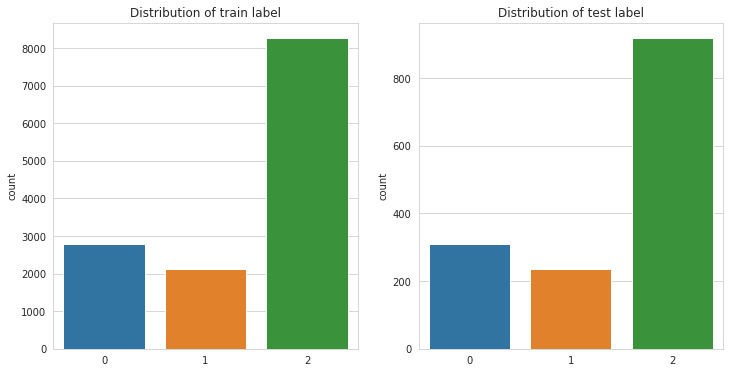

In [39]:
train_data,test_data,train_label,test_label = train_test_split(data,label,test_size=0.1,stratify=label,random_state=42)

print("shape of train data >>",train_data.shape)
print("shape of test data >>",test_data.shape)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
sns.countplot(x=np.argmax(train_label,axis=1))
plt.title("Distribution of train label")

ax2 = fig.add_subplot(1,2,2)
sns.countplot(x=np.argmax(test_label,axis=1))
plt.title("Distribution of test label")
plt.show()

index_to_sentiment = {
    0:'neutral',
    1:'positive',
    -1:'negative'
}

##LSTM model using pre-trained embedding vectors

In [40]:
embedding_dict=dict()

f = open(os.path.join('glove.6B.100d.txt'),encoding='utf-8')
for line in f:
    tokens = line.split()
    word = tokens[0]
    word_vector = np.asarray(tokens[1:],dtype='float32')
    embedding_dict[word] = word_vector

f.close()

print(f"There are {len(embedding_dict)} embedding vectors in total")
print(f"Dimension of each vector >> {len(embedding_dict['read'])}")
embedding_size = len(embedding_dict['read'])


embedding_matrix = np.zeros((vocab_size,embedding_size))

for word,idx in tokenizer.word_index.items():
    if idx <= 7000:
        vector = embedding_dict.get(word)
        if vector is not None:
            embedding_matrix[idx] = np.asarray(vector,dtype='float32')

There are 400000 embedding vectors in total
Dimension of each vector >> 100


LSTM model (+ bidirectional, many-to-many)

In [41]:
from keras.layers import Input,Embedding,TimeDistributed,Bidirectional,LSTM,BatchNormalization,Dense,GlobalMaxPool1D,GlobalAveragePooling1D,Dropout,Masking
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.utils import plot_model

word_vec_size=100
hidden_size=128

def create_lstm():
    X = Input(shape=[sequence_size])
    H = Embedding(vocab_size,word_vec_size,input_length=sequence_size,weights=[embedding_matrix],trainable=False)(X)
    H = Masking(mask_value=0.0)(H)
    
    H = Bidirectional(LSTM(hidden_size,return_sequences=True))(H)
    H = Bidirectional(LSTM(int(hidden_size/2),return_sequences=True))(H)
    H = Bidirectional(LSTM(int(hidden_size/2),return_sequences=True))(H)
    
    H = GlobalMaxPool1D()(H)
    H = BatchNormalization()(H)
    H = Dense(32,activation='relu')(H)
    H = BatchNormalization()(H)
    Y = Dense(3,activation='softmax')(H)
    
    model = keras.models.Model(X,Y)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

es = EarlyStopping(monitor='val_accuracy',mode='min',patience=4,verbose=1)
rl = ReduceLROnPlateau(monitor='val_loss',mode='min',patience=3,verbose=1)

In [42]:
lstm_model = create_lstm()
plot_model(lstm_model)
lstm_history = lstm_model.fit(train_data,train_label,epochs=10,batch_size=64,validation_split=0.2,callbacks=[rl])
lstm_model.evaluate(test_data,test_label)

Epoch 1/10
165/165 [==============================] - 84s 332ms/step - loss: 0.7650 - accuracy: 0.6861 - val_loss: 0.7948 - val_accuracy: 0.6574 - lr: 0.0010
Epoch 2/10
165/165 [==============================] - 46s 281ms/step - loss: 0.5923 - accuracy: 0.7620 - val_loss: 0.7367 - val_accuracy: 0.6992 - lr: 0.0010
Epoch 3/10
165/165 [==============================] - 44s 264ms/step - loss: 0.5451 - accuracy: 0.7783 - val_loss: 0.6842 - val_accuracy: 0.7253 - lr: 0.0010
Epoch 4/10
165/165 [==============================] - 45s 273ms/step - loss: 0.5055 - accuracy: 0.7902 - val_loss: 0.6202 - val_accuracy: 0.7659 - lr: 0.0010
Epoch 5/10
165/165 [==============================] - 46s 281ms/step - loss: 0.4761 - accuracy: 0.8080 - val_loss: 0.5671 - val_accuracy: 0.7781 - lr: 0.0010
Epoch 6/10
165/165 [==============================] - 48s 292ms/step - loss: 0.4414 - accuracy: 0.8187 - val_loss: 0.6960 - val_accuracy: 0.7511 - lr: 0.0010
Epoch 7/10
165/165 [==============================] 

[0.6660506725311279, 0.7581967115402222]

##LSTM model without using pre-trained embedding vectors

In [43]:
word_vec_size=100
hidden_size=256

def create_lstm_no_emb():
    X = Input(shape=[sequence_size])
    H = Embedding(vocab_size,word_vec_size,input_length=sequence_size)(X)
    H = Masking(mask_value=0.0)(H)
    
    H = Bidirectional(LSTM(hidden_size,return_sequences=True))(H)
    H = BatchNormalization()(H)
    H = Bidirectional(LSTM(int(hidden_size/2),return_sequences=True))(H)
    H = BatchNormalization()(H)
    H = Bidirectional(LSTM(int(hidden_size/2),return_sequences=True))(H)
    
    H = GlobalMaxPool1D()(H)
    H = Dense(64,activation='relu')(H)
    H = Dense(32,activation='relu')(H)
    H = Dropout(0.2)(H)
    Y = Dense(3,activation='softmax')(H)
    
    model = keras.models.Model(X,Y)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [44]:
lstm_no = create_lstm_no_emb()
plot_model(lstm_no)
lstm_no_hist = lstm_model.fit(train_data,train_label,epochs=15,batch_size=64,validation_split=0.2,callbacks=[rl])
lstm_no.evaluate(test_data,test_label)

Epoch 1/15
165/165 [==============================] - 44s 266ms/step - loss: 0.2239 - accuracy: 0.9174 - val_loss: 0.6798 - val_accuracy: 0.7644 - lr: 1.0000e-04
Epoch 2/15
165/165 [==============================] - 45s 273ms/step - loss: 0.2127 - accuracy: 0.9231 - val_loss: 0.6544 - val_accuracy: 0.7766 - lr: 1.0000e-04
Epoch 3/15
165/165 [==============================] - 46s 280ms/step - loss: 0.1981 - accuracy: 0.9304 - val_loss: 0.6716 - val_accuracy: 0.7712 - lr: 1.0000e-04
Epoch 4/15
165/165 [==============================] - 48s 289ms/step - loss: 0.1878 - accuracy: 0.9330 - val_loss: 0.7010 - val_accuracy: 0.7693 - lr: 1.0000e-04
Epoch 5/15
165/165 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.9384
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
165/165 [==============================] - 46s 282ms/step - loss: 0.1752 - accuracy: 0.9384 - val_loss: 0.7249 - val_accuracy: 0.7678 - lr: 1.0000e-04
Epoch 6/15
165/165 [========

[1.0997459888458252, 0.16051912307739258]

##Conv1D model using pre-trained Embedding Vectors

In [45]:
from keras.layers import Conv1D,Concatenate,LeakyReLU,Flatten

def create_conv1d():
    X = Input(shape=[sequence_size])
    H = Embedding(vocab_size,word_vec_size,input_length=sequence_size,weights=[embedding_matrix],trainable=False,mask_zero=True)(X)
    H = Dropout(0.3)(H)
    
    num_filters=[256,256,128,128]
    kernel_sizes=[3,4,5,6]
    conv_blocks=[]
    
    for i in range(len(kernel_sizes)):
        conv = Conv1D(filters=num_filters[i],kernel_size=kernel_sizes[i],padding='valid',activation='relu')(H)
        conv = GlobalMaxPool1D()(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)
    
    H = Concatenate()(conv_blocks)
    H = Dropout(0.2)(H)
    
    H = Dense(128)(H)
    H = BatchNormalization()(H)
    H = LeakyReLU()(H)
    
    H = Dense(16)(H)
    H = BatchNormalization()(H)
    H = LeakyReLU()(H)
    
    Y = Dense(3,activation='softmax')(H)
    
    model = keras.models.Model(X,Y)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [46]:
conv1d = create_conv1d()
plot_model(conv1d)
hist = conv1d.fit(train_data,train_label,epochs=10,validation_split=0.2,batch_size=64,callbacks=[rl])
conv1d.evaluate(test_data,test_label)

Epoch 1/10
165/165 [==============================] - 11s 54ms/step - loss: 0.7930 - accuracy: 0.6757 - val_loss: 0.6154 - val_accuracy: 0.7504 - lr: 0.0010
Epoch 2/10
165/165 [==============================] - 8s 49ms/step - loss: 0.6085 - accuracy: 0.7518 - val_loss: 0.5674 - val_accuracy: 0.7663 - lr: 0.0010
Epoch 3/10
165/165 [==============================] - 8s 49ms/step - loss: 0.5520 - accuracy: 0.7764 - val_loss: 0.6119 - val_accuracy: 0.7572 - lr: 0.0010
Epoch 4/10
165/165 [==============================] - 9s 52ms/step - loss: 0.5108 - accuracy: 0.7920 - val_loss: 0.5512 - val_accuracy: 0.7766 - lr: 0.0010
Epoch 5/10
165/165 [==============================] - 7s 44ms/step - loss: 0.4730 - accuracy: 0.8100 - val_loss: 0.5508 - val_accuracy: 0.7785 - lr: 0.0010
Epoch 6/10
165/165 [==============================] - 9s 52ms/step - loss: 0.4423 - accuracy: 0.8192 - val_loss: 0.5494 - val_accuracy: 0.7712 - lr: 0.0010
Epoch 7/10
165/165 [==============================] - 9s 52ms/s

[0.6005133390426636, 0.7704917788505554]